In [2]:
import json
import requests
import time
import itertools
from typing import List
from collections import Counter
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<h3>Load the HPO ontology (Release 2023-07-21)</h3>

In [3]:
f = open("ontologies/hp.json")
data = json.load(f)

In [4]:
def getHPO(url: str) -> str:
    '''
    Gets the url stored in the HPO ontology in the following format
    http://putl.obolibrary.org/obo/HP_XXXXXXXX
    and returns the HPO code in the following format
    HP_XXXXXXXX
    '''
    return url.split('/',5)[4]

In [5]:
def traverseGraph(url: str, n: int, data=data) -> str:
    '''
    Given a url (HPO id in the HPO ontology) and a int n
    move through the ontology n levels above (n > 0) or n levels
    below (n < 0). If not enough levels, return the maximum reached
    '''
    if n < 0:
        direction = 'sub'
        current = 'obj'
    else:
        direction = 'obj'
        current = 'sub'
    n = abs(n)
    for j in range(n):
        cand = []
        for i in data['graphs'][0]['edges']:
            if(url == i[current]):
                cand.append(i[direction])
        url = random.choice(cand) if len(cand) > 0 else url
    return url

In [6]:
def prepareRequest(arr: List[str]) -> str:
    '''
    Given an array (arr) with format [setA,setB], where setA and setB are lists of HPO
    return a string in the following format
    HPOA1,HPOA2,...,HPOAN/HPOB1,HPOB2,...,HPOBN
    where HPOA and HPOB belong to setA and setB respectively
    '''
    s = ''
    j = 0
    for i in arr[0]:
        s += i
        if(j<len(arr[0])-1):
            s += ','
        j+=1
    s += '/'
    j = 0
    for i in arr[1]:
        s += i
        if(j<len(arr[1])-1):
            s += ','
        j+=1
    return s

<h3>Testing the Monarch Initiative API with simple tests</h3>

In [7]:
randomHPO = random.sample(range(len(data['graphs'][0]['nodes'])),5)

In [8]:
setA_1 = []
for i in randomHPO:
    setA_1.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
setA_1 = list(map(lambda x: x.replace('_',':'), setA_1))
setA_1

['HP:0012318', 'HP:0002071', 'HP:0033854', 'HP:0033610', 'HP:0007332']

In [9]:
randomHPO1= random.sample(range(len(data['graphs'][0]['nodes'])),5)

In [10]:
setB_1 = []
for i in randomHPO1:
    setB_1.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
setB_1 = list(map(lambda x: x.replace('_',':'), setB_1))

<p>Test 1: Two random sets of equal length (setA_1,setB_1)</p>

In [11]:
print(setA_1,setB_1)

['HP:0012318', 'HP:0002071', 'HP:0033854', 'HP:0033610', 'HP:0007332'] ['HP:0012504', 'HP:0008186', 'HP:0040035', 'HP:0034594', 'HP:0011587']


In [12]:
# Factor of noise in Test 3
random_noise = [-3,-2,-1,1,2,3]

In [13]:
setB_2 = []
for i in randomHPO:
    setB_2.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(random_noise))))
setB_2 = list(map(lambda x: x.replace('_',':'), setB_2))

<p>Test 3: One random set (setA_1) and setB_2 consisting of HPO n levels above or below in the ontology</p>
<p>In this case n between -3 and 3 both included and 0 excluded</p>

In [14]:
print(setA_1,setB_2)

['HP:0012318', 'HP:0002071', 'HP:0033854', 'HP:0033610', 'HP:0007332'] ['HP:0012318', 'HP:0007308', 'HP:0033968', 'HP:0033608', 'HP:0032854']


In [15]:
# Factor of generalization of terms (n terms above in the ontology)
generalizer = [2,3,4]

In [16]:
setB_3 = []
for i in randomHPO:
    setB_3.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
setB_3 = list(map(lambda x: x.replace('_',':'), setB_3))

<p>Test 5: One random set (setA_1) and setB_3 consisting of HPO n levels above in the ontology</p>
<p>In this case n between 2 and 4 both included</p>

In [17]:
print(setA_1,setB_3)

['HP:0012318', 'HP:0002071', 'HP:0033854', 'HP:0033610', 'HP:0007332'] ['HP:0012531', 'HP:0000707', 'HP:0033835', 'HP:0002086', 'HP:0020219']


<p>6 tests are defined, where test2, test4 and test6 are control tests on test1, test3 and test5 respectively</p> 

In [18]:
test1 = [setA_1,setA_1]
test2 = [setA_1,setB_1]
test3 = [setA_1,setB_2]
test4 = [setB_1,setB_2]
test5 = [setA_1, setB_3]
test6 = [setB_1, setB_3]

<p>The json response has the following format</p>

In [19]:
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/' + prepareRequest(test1))
response.json()

{'subject_termset': {'HP:0007332': {'id': 'HP:0007332',
   'label': 'Focal hemifacial clonic seizure'},
  'HP:0033610': {'id': 'HP:0033610', 'label': 'Subsolid pulmonary nodule'},
  'HP:0012318': {'id': 'HP:0012318', 'label': 'Occipital neuralgia'},
  'HP:0033854': {'id': 'HP:0033854',
   'label': 'Abnormal interlobular vein morphology'},
  'HP:0002071': {'id': 'HP:0002071',
   'label': 'Abnormality of extrapyramidal motor function'}},
 'object_termset': {'HP:0007332': {'id': 'HP:0007332',
   'label': 'Focal hemifacial clonic seizure'},
  'HP:0033610': {'id': 'HP:0033610', 'label': 'Subsolid pulmonary nodule'},
  'HP:0012318': {'id': 'HP:0012318', 'label': 'Occipital neuralgia'},
  'HP:0033854': {'id': 'HP:0033854',
   'label': 'Abnormal interlobular vein morphology'},
  'HP:0002071': {'id': 'HP:0002071',
   'label': 'Abnormality of extrapyramidal motor function'}},
 'subject_best_matches': {'HP:0002071': {'match_source': 'HP:0002071',
   'match_source_label': 'Abnormality of extrapyra

In [20]:
array_test = [test1,test2,test3,test4,test5,test6]

In [21]:
for i in range(len(array_test)):
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[i]))
    average_score = response.json()['average_score']
    print(f'Test {i+1}: Average score: {average_score}')

Test 1: Average score: 16.07624658111643
Test 2: Average score: 5.138030027158525
Test 3: Average score: 15.79323908126066
Test 4: Average score: 5.138030027158525
Test 5: Average score: 10.138328416318162
Test 6: Average score: 4.88578547162113


<h4>Testing the 3 different algorithms available on Monarch Initiative with the 6 tests explained above (N = 50)</h4>

In [22]:
N = 50
matrix_AIC = np.zeros([6,N])
matrix_JAC = np.zeros([6,N])
matrix_PHE = np.zeros([6,N])

random.seed(12)

for j in range(N):
    randomHPO = random.sample(range(5,len(data['graphs'][0]['nodes'])-23),10)

    setA_1 = []
    for i in randomHPO:
        setA_1.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
    setA_1 = list(map(lambda x: x.replace('_',':'), setA_1))

    randomHPO1 = random.sample(range(5,len(data['graphs'][0]['nodes'])-23),10)

    setB_1 = []
    for i in randomHPO1:
        setB_1.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
    setB_1 = list(map(lambda x: x.replace('_',':'), setB_1))

    random_noise = [-3,-2,-1,1,2,3]
    setB_2 = []
    for i in randomHPO:
        setB_2.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(random_noise))))
    setB_2 = list(map(lambda x: x.replace('_',':'), setB_2))

    generalizer = [1,2,3,4]
    setB_3 = []
    for i in randomHPO:
        setB_3.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
    setB_3 = list(map(lambda x: x.replace('_',':'), setB_3))

    test1 = [setA_1,setA_1]
    test2 = [setA_1,setB_1]
    test3 = [setA_1,setB_2]
    test4 = [setB_1,setB_2]
    test5 = [setA_1, setB_3]
    test6 = [setB_1, setB_3]

    array_test = [test1,test2,test3,test4,test5,test6]

    for i in range(len(array_test)):
        response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[i]) + '?metric=ancestor_information_content')
        matrix_AIC[i][j] = response.json()['average_score']

        response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[i]) + '?metric=jaccard_similarity')
        matrix_JAC[i][j] = response.json()['average_score']

        response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[i]) + '?metric=phenodigm_score')
        matrix_PHE[i][j] = response.json()['average_score']

<h1>Results</h1>

In [23]:
j = 1
for i in matrix_AIC:
    print(f'Test {j}:  {np.array(i).mean()}')
    j+=1

Test 1:  17.197377637920184
Test 2:  7.444363574601536
Test 3:  14.782482672025472
Test 4:  7.319625631222254
Test 5:  11.360872995034986
Test 6:  6.9204669838639505


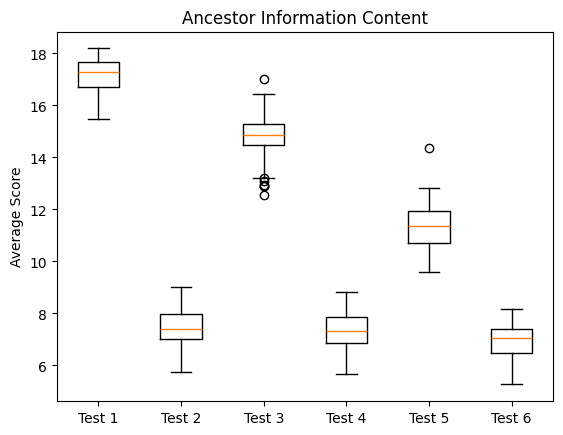

In [24]:
boxplot_data = [
    matrix_AIC[0],
    matrix_AIC[1],
    matrix_AIC[2],
    matrix_AIC[3],
    matrix_AIC[4],
    matrix_AIC[5]
]
labels = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']

fig, ax = plt.subplots()
plt.title('Ancestor Information Content')
ax.set_ylabel('Average Score')

bplot = ax.boxplot(boxplot_data,
                   tick_labels=labels)

plt.show()

In [25]:
j = 1
for i in matrix_JAC:
    print(f'Test {j}:  {np.array(i).mean()}')
    j+=1

Test 1:  1.0
Test 2:  0.3875498225241882
Test 3:  0.8688185475912572
Test 4:  0.4000312238150127
Test 5:  0.726676708552509
Test 6:  0.43197905729631586


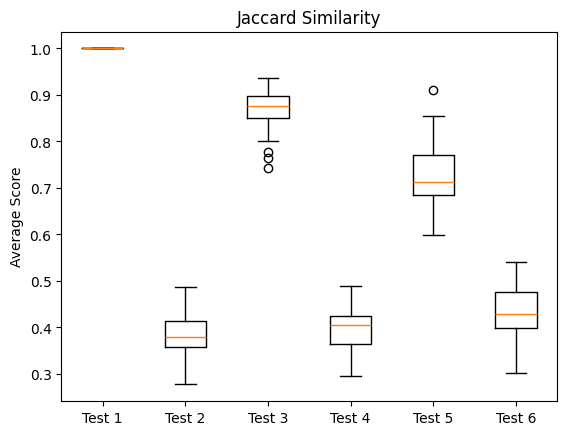

In [26]:
boxplot_data = [
    matrix_JAC[0],
    matrix_JAC[1],
    matrix_JAC[2],
    matrix_JAC[3],
    matrix_JAC[4],
    matrix_JAC[5]
]
labels = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']

fig, ax = plt.subplots()
plt.title('Jaccard Similarity')
ax.set_ylabel('Average Score')

bplot = ax.boxplot(boxplot_data,
                   tick_labels=labels)

plt.show()

In [27]:
j = 1
for i in matrix_PHE:
    print(f'Test {j}:  {np.array(i).mean()}')
    j+=1

Test 1:  4.13873983060814
Test 2:  1.6336883918409055
Test 3:  3.558149857876737
Test 4:  1.6400738808419357
Test 5:  2.827947302674293
Test 6:  1.6613541857734702


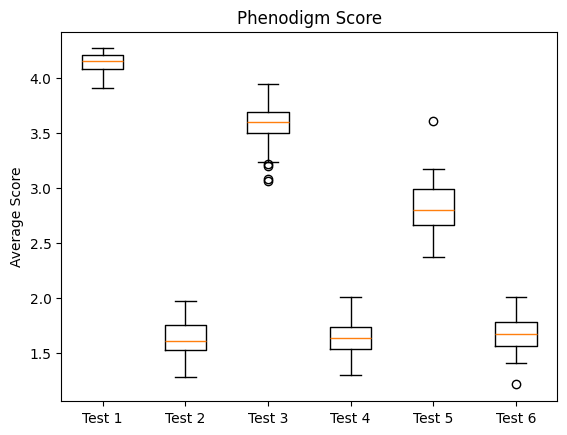

In [28]:
boxplot_data = [
    matrix_PHE[0],
    matrix_PHE[1],
    matrix_PHE[2],
    matrix_PHE[3],
    matrix_PHE[4],
    matrix_PHE[5]
]
labels = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']

fig, ax = plt.subplots()
plt.title('Phenodigm Score')
ax.set_ylabel('Average Score')

bplot = ax.boxplot(boxplot_data,
                   tick_labels=labels)

plt.show()

<h2>Further tests on behaviour on the AIC algortihm of the Monarch Initiative</h2>
<p>We define a fix setB with 10 random HPO<p>

In [29]:
random.seed(12)
randomHPO = random.sample(range(len(data['graphs'][0]['nodes'])),10)

setB = []
for i in randomHPO:
    setB.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
setB = list(map(lambda x: x.replace('_',':'), setB))
setB

['HP:0040248',
 'HP:0012157',
 'HP:0500132',
 'HP:0031088',
 'HP:0006955',
 'HP:0032182',
 'HP:0000458',
 'HP:0031946',
 'HP:0045036',
 'HP:0012323']

<p>Test 1 has a SetA with 5 generalized HPO of SetB</p>

In [30]:
generalizer = [2,3,4]
test1 = []
for i in randomHPO:
    test1.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
test1 = list(map(lambda x: x.replace('_',':'), test1))
test1 = random.sample(test1, 5)
test1

['HP:0000008', 'HP:0007360', 'HP:0011893', 'HP:0010892', 'HP:0003110']

<p>Test 2 has a SetA with 10 generalized HPO of SetB</p>

In [31]:
test2 = []
for i in randomHPO:
    test2.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
test2 = list(map(lambda x: x.replace('_',':'), test2))
test2

['HP:0001871',
 'HP:0002977',
 'HP:0033107',
 'HP:0000812',
 'HP:0012639',
 'HP:0004332',
 'HP:0000234',
 'HP:0033354',
 'HP:0011277',
 'HP:0011442']

Test 3 has a SetA with 10 generalized HPO of SetB and an additional 5 random HPO as noise

In [32]:
test3 = []
ar_t3 = random.sample(range(len(data['graphs'][0]['nodes'])),5)
for i in randomHPO:
    test3.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(random_noise))))
for j in ar_t3:
    test3.append(getHPO(data['graphs'][0]['nodes'][j]['id']))

test3 = list(map(lambda x: x.replace('_',':'), test3))
test3

['HP:0001871',
 'HP:0007132',
 'HP:0500132',
 'HP:0031088',
 'HP:0007360',
 'HP:0011839',
 'HP:0000366',
 'HP:0031946',
 'HP:0001939',
 'HP:0004305',
 'HP:0008326',
 'HP:0034920',
 'HP:0031581',
 'HP:0009182',
 'HP:0009435']

<p>Test 4 has a SetA build searching for terms N levels above and below the terms on SetB.<p>
<p>In this case N = 3 and max length = 30<p> 

In [33]:
test4 = []
N = 30
for j in range(N):
    i = random.choice(randomHPO)
    test4.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(random_noise))))

test4 = list(map(lambda x: x.replace('_',':'), test4))
test4 = list(set(test4))
len(test4)

25

<h4>Testing the 4 tests explained above (N = 50)</h4>

In [34]:
N = 50
matrix = np.zeros([4,N])

random.seed(12)

for k in range(N):
    randomHPO = random.sample(range(5,len(data['graphs'][0]['nodes'])-23),10)

    setB = []
    for i in randomHPO:
        setB.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
    setB = list(map(lambda x: x.replace('_',':'), setB))

    test1 = []
    for i in randomHPO:
        test1.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
    test1 = list(map(lambda x: x.replace('_',':'), test1))
    test1 = random.sample(test1, 5)

    test2 = []
    for i in randomHPO:
        test2.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
    test2 = list(map(lambda x: x.replace('_',':'), test2))

    test3 = []
    ar_t3 = random.sample(range(5,len(data['graphs'][0]['nodes'])-23),5)
    for i in randomHPO:
        test3.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
    for j in ar_t3:
        test3.append(getHPO(data['graphs'][0]['nodes'][j]['id']))

    test3 = list(map(lambda x: x.replace('_',':'), test3))

    test4 = []
    N = 30
    for j in range(N):
        i = random.choice(randomHPO)
        test4.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))

    test4 = list(map(lambda x: x.replace('_',':'), test4))
    test4 = list(set(test4))

    test1 = [test1,setB]
    test2 = [test2,setB]
    test3 = [test3,setB]
    test4 = [test4,setB]

    array_test = [test1,test2,test3,test4]

    for i in range(len(array_test)):
        response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[i]) + '?metric=ancestor_information_content')
        matrix[i][k] = response.json()['average_score']


<h1>Results</h1>

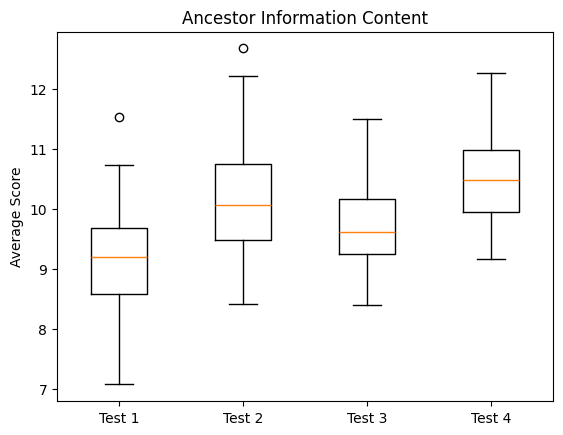

In [35]:
boxplot_data = [
    matrix[0],
    matrix[1],
    matrix[2],
    matrix[3]
]
labels = ['Test 1', 'Test 2', 'Test 3', 'Test 4']

fig, ax = plt.subplots()
plt.title('Ancestor Information Content')
ax.set_ylabel('Average Score')

bplot = ax.boxplot(boxplot_data,
                   tick_labels=labels)

plt.show()

<h2>Studying the behaviour of the algorithm with variable setA and setB length</h2>

In [36]:
N = 300
random.seed(12)
l = []
l1 = []
duration = []
for j in range(N):
    numHPO = random.randint(5,100)
    randomHPO = random.sample(range(5,len(data['graphs'][0]['nodes'])-23),numHPO)

    setA = []
    for i in randomHPO:
        setA.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
    setA = list(map(lambda x: x.replace('_',':'), setA))

    randomHPO1 = random.sample(range(5,len(data['graphs'][0]['nodes'])-23),10)

    setB_1 = []
    for i in randomHPO1:
        setB_1.append(getHPO(data['graphs'][0]['nodes'][i]['id']))
    setB_1 = list(map(lambda x: x.replace('_',':'), setB_1))

    setB_2 = []
    for i in randomHPO:
        setB_2.append(getHPO(traverseGraph(data['graphs'][0]['nodes'][i]['id'],random.choice(generalizer))))
    setB_2 =  list(map(lambda x: x.replace('_',':'), setB_2))

    array_test = [[setA,setB_1],[setA,setB_2]]
    start = time.time()
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[0]) + '?metric=ancestor_information_content')
    response1 = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest(array_test[1]) + '?metric=ancestor_information_content')
    end = time.time()
    l.append([numHPO,response.json()['average_score']])
    l1.append([numHPO,response1.json()['average_score']])
    duration.append([numHPO,end-start])

<h1>Results</h1>

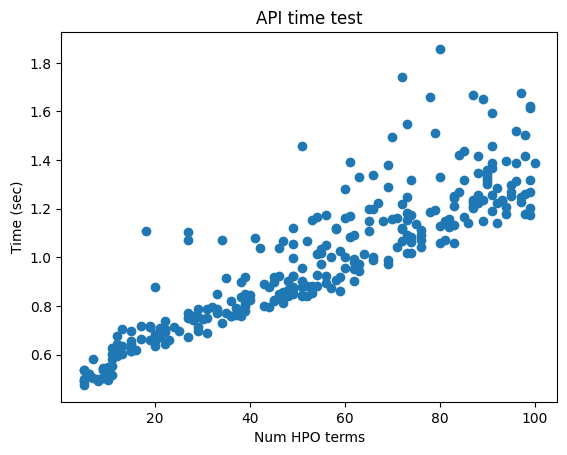

In [37]:
plt.scatter([row[0] for row in duration],[row[1]/2 for row in duration])
plt.xlabel('Num HPO terms')
plt.ylabel('Time (sec)')
plt.title('API time test')

plt.show()

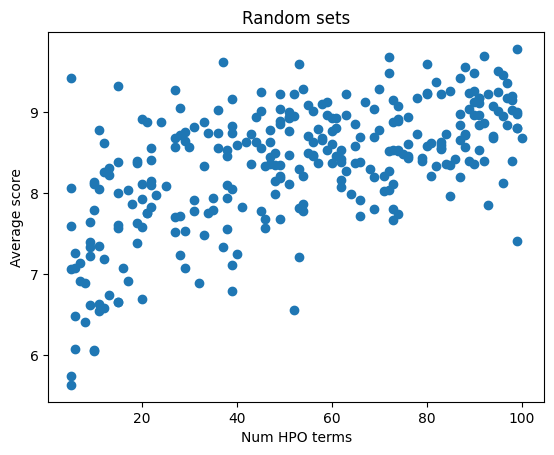

In [38]:
plt.scatter([row[0] for row in l],[row[1] for row in l])
plt.xlabel('Num HPO terms')
plt.ylabel('Average score')
plt.title('Random sets')

plt.show()

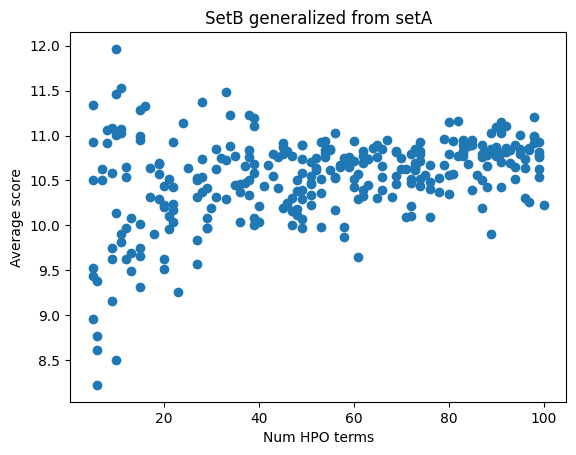

In [39]:
plt.scatter([row[0] for row in l1],[row[1] for row in l1])
plt.xlabel('Num HPO terms')
plt.ylabel('Average score')
plt.title('SetB generalized from setA')

plt.show()

<h1>Firsts tests on phenotype classification</h1>

In [40]:
g1 = []
g2 = []
g3 = []

<p>We define 3 groups,g1 ,g2 and g3, following normal distribution centered around 0.25, 0.5 and 0.75 respectively. (Sigma = 0.5)</p>

In [41]:
while(len(g1) < 100000):
    val = random.gauss(0.25,0.5)
    if 0 < val < 1:
        g1.append(val)

while(len(g2) < 100000):
    val = random.gauss(0.5,0.5)
    if 0 < val < 1:
        g2.append(val)

while(len(g3) < 100000):
    val = random.gauss(0.75,0.5)
    if 0 < val < 1:
        g3.append(val)

<p>Mapping the three distinct groups populated with 100000 instances to their respective HPO term</p>

In [42]:
g1 = list(map(lambda x: data['graphs'][0]['nodes'][round(x*len(data['graphs'][0]['nodes'])-23)+5]['id'],g1))
g2 = list(map(lambda x: data['graphs'][0]['nodes'][round(x*len(data['graphs'][0]['nodes'])-23)+5]['id'],g2))
g3 = list(map(lambda x: data['graphs'][0]['nodes'][round(x*len(data['graphs'][0]['nodes'])-23)+5]['id'],g3))

<h3>Extracting most significant HPO of each group as method of comparison</h3>
<p>In this case we will select the 100 most occuring HPO in a group and all HPO whose frequency between groups is above 85%</p>

In [43]:
cg1 = Counter(g1)
cg2 = Counter(g2)
cg3 = Counter(g3)

In [44]:
totalCount = cg1 + cg2 + cg3

In [45]:
bestG1 = list(cg1.keys())[0:100]
bestG2 = list(cg2.keys())[0:100]
bestG3 = list(cg3.keys())[0:100]

In [46]:
for i in cg1.keys():
    div = cg1[i]/totalCount[i]
    if div > 0.85:
        bestG1.append(i)

for i in cg2.keys():
    div = cg2[i]/totalCount[i]
    if div > 0.85:
        bestG2.append(i)

for i in cg3.keys():
    div = cg3[i]/totalCount[i]
    if div > 0.85:
        bestG3.append(i)

<p>Testing random sample of g1 and size 40 with all 3 distict groups<p>

In [47]:
testA = random.sample(g1, 40)
testB1 = list(set(bestG1))
testB2 = list(set(bestG2))
testB3 = list(set(bestG3))

In [48]:
testA = list(map(lambda x: getHPO(x), testA))
testA = list(map(lambda x: x.replace('_',':'), testA))

testB1 = list(map(lambda x: getHPO(x), testB1))
testB1 = list(map(lambda x: x.replace('_',':'), testB1))

testB2 = list(map(lambda x: getHPO(x), testB2))
testB2 = list(map(lambda x: x.replace('_',':'), testB2))

testB3 = list(map(lambda x: getHPO(x), testB3))
testB3 = list(map(lambda x: x.replace('_',':'), testB3))

In [49]:
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([testA, testB1]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([testA, testB2]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([testA, testB3]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])


10.105234287815602
9.914486667315908
9.834562725356824


<p>Small visualization of database mapping HPO terms to associated genes and disease<p>

In [50]:
phen_to_genes = pd.read_csv('ontologies/phenotype_to_genes.txt', sep='\t')

In [51]:
phen_to_genes.head()

,hpo_id,hpo_name,ncbi_gene_id,gene_symbol,disease_id
0,HP:0004808,Acute myeloid leukemia,2672,GFI1,OMIM:607847
1,HP:0004808,Acute myeloid leukemia,2672,GFI1,ORPHA:486
2,HP:0004808,Acute myeloid leukemia,675,BRCA2,OMIM:605724
3,HP:0004808,Acute myeloid leukemia,675,BRCA2,OMIM:613029
4,HP:0004808,Acute myeloid leukemia,128,ADH5,OMIM:619151


In [52]:
def genes_info(setA: List[str], setB: List[str], data=phen_to_genes) -> dict:
    '''
    Gets two HPO sets (setA and setB) and the phen_to_genes data and returns
    all genes associated with both HPO terms of both sets and the number of times it
    is found in each set.
    '''
    gSetA = []
    gSetB = []
    for i in range(len(data['hpo_id'])):
        if(data['hpo_id'][i] in setA):
            gSetA.append(data['gene_symbol'][i])
        if(data['hpo_id'][i] in setB):
            gSetB.append(data['gene_symbol'][i])
    
    d = dict((el,0) for el in set.intersection(set(gSetA),set(gSetB)))

    for i in gSetA:
        if i in d.keys():
            d[i]+=1
    
    for i in gSetB:
        if i in d.keys():
            d[i]+=1

    return d

In [53]:
genes_info(test2, setB, phen_to_genes)

{}

<h1>Testing the classification method with more realistic data</h1>
<p>The 4 groups (Cardiovascular, Respiratory, Immunology, Neurologic) are populated with data from OMIM. 200 disease of each class and their respective associated<p>
<p>HPO terms are loaded onto their respective group.<p>

In [54]:
cardio = pd.read_csv('disease/Cardiovascular.tsv', sep='\t')
resp = pd.read_csv('disease/Respiratory.tsv', sep='\t')
immuno = pd.read_csv('disease/Immunology.tsv', sep='\t')
neuro = pd.read_csv('disease/Neurologic.tsv', sep='\t')

In [55]:
cardio.head()

,MIM Number,Title,Entrez Gene ID
0,#300373,OSTEOPATHIA STRIATA WITH CRANIAL SCLEROSIS; OSCS,NaN
1,#300376,"MUSCULAR DYSTROPHY, BECKER TYPE; BMD",NaN
2,#300438,HSD10 MITOCHONDRIAL DISEASE; HSD10MD,NaN
3,#300539,NEPHROGENIC SYNDROME OF INAPPROPRIATE ANTIDIUR...,NaN
4,#300590,CORNELIA DE LANGE SYNDROME 2; CDLS2,NaN


In [56]:
resp.head()

,MIM Number,Title,Entrez Gene ID
0,#300373,OSTEOPATHIA STRIATA WITH CRANIAL SCLEROSIS; OSCS,NaN
1,#300400,"SEVERE COMBINED IMMUNODEFICIENCY, X-LINKED; SC...",NaN
2,#300455,"RETINITIS PIGMENTOSA, X-LINKED, AND SINORESPIR...",NaN
3,#300635,"LYMPHOPROLIFERATIVE SYNDROME, X-LINKED, 2; XLP2",NaN
4,#300672,DEVELOPMENTAL AND EPILEPTIC ENCEPHALOPATHY 2; ...,NaN


In [57]:
immuno.head()

,MIM Number,Title,Entrez Gene ID
0,#300400,"SEVERE COMBINED IMMUNODEFICIENCY, X-LINKED; SC...",NaN
1,#300635,"LYMPHOPROLIFERATIVE SYNDROME, X-LINKED, 2; XLP2",NaN
2,#300636,IMMUNODEFICIENCY 33; IMD33,NaN
3,#300645,IMMUNODEFICIENCY 34; IMD34,NaN
4,#300755,"AGAMMAGLOBULINEMIA, X-LINKED; XLA",NaN


In [58]:
neuro.head()

,MIM Number,Title,Entrez Gene ID
0,#300373,OSTEOPATHIA STRIATA WITH CRANIAL SCLEROSIS; OSCS,NaN
1,#300376,"MUSCULAR DYSTROPHY, BECKER TYPE; BMD",NaN
2,#300387,"INTELLECTUAL DEVELOPMENTAL DISORDER, X-LINKED ...",NaN
3,#300400,"SEVERE COMBINED IMMUNODEFICIENCY, X-LINKED; SC...",NaN
4,#300419,"INTELLECTUAL DEVELOPMENTAL DISORDER, X-LINKED ...",NaN


In [59]:
def getOMIM(data : list[str]) -> list[str]:
    '''
    Gets an array with format #XXXXXX and returns the array in format OMIM:XXXXXX
    '''
    for i in range(len(data)):
        data[i] = data[i].replace('#','OMIM:')
    return data

In [60]:
lNeuro = getOMIM(list(neuro['MIM Number']))
lImmuno = getOMIM(list(immuno['MIM Number']))
lCardio = getOMIM(list(cardio['MIM Number']))
lResp = getOMIM(list(resp['MIM Number']))

<p>We remove disease not present in our database mapping disease and HPO terms<p>

In [61]:
for i in lNeuro:
    if i not in list(phen_to_genes['disease_id']):
        lNeuro.remove(i)
for i in lImmuno:
    if i not in list(phen_to_genes['disease_id']):
        lImmuno.remove(i)

for i in lCardio:
    if i not in list(phen_to_genes['disease_id']):
        lCardio.remove(i)

for i in lResp:
    if i not in list(phen_to_genes['disease_id']):
        lResp.remove(i)

In [62]:
print(len(lNeuro),len(lImmuno),len(lCardio),len(lResp))

185 189 191 190


<p>How much overlap is there between disease in each group?</p>

In [63]:
print(len(set.intersection(set(lNeuro),set(lImmuno))))
print(len(set.intersection(set(lNeuro),set(lCardio))))
print(len(set.intersection(set(lNeuro),set(lResp))))
print(len(set.intersection(set(lImmuno),set(lCardio))))
print(len(set.intersection(set(lImmuno),set(lResp))))
print(len(set.intersection(set(lCardio),set(lResp))))

22
49
38
15
34
63


In [64]:
def getHPOFromOMIM(l : List[str], data=phen_to_genes) -> dict:
    '''
    Gets list of disease and the phen_to_genes database and returns a 
    dictionary mapping each disease to their HPO terms
    '''
    d = dict((el,[]) for el in l)
    
    for i in range(len(data['hpo_id'])):
        if data['disease_id'][i] in l:
            d[data['disease_id'][i]].append(data['hpo_id'][i])
    
    return d

In [65]:
dNeuro = getHPOFromOMIM(lNeuro)
dImmuno = getHPOFromOMIM(lImmuno)
dCardio = getHPOFromOMIM(lCardio)
dResp = getHPOFromOMIM(lResp)

In [66]:
def flatten(l : List[List]) -> List:
    '''
    Transforms a 2D array into a list
    '''
    return list(itertools.chain.from_iterable(l))

In [67]:
HPONeuro = Counter(flatten(list(dNeuro.values())))
HPOImmuno = Counter(flatten(list(dImmuno.values())))
HPOCardio = Counter(flatten(list(dCardio.values())))
HPOResp = Counter(flatten(list(dResp.values())))

In [68]:
totalNum = HPONeuro + HPOImmuno + HPOCardio + HPOResp

In [69]:
def sigmoid(x, a=-10, b=10):
    '''
    Gets a number x between between 0 and 1 and returns sigmoid(x),
    where sigmoid is centered and resized around [0,1]
    '''
    x1 = (x * (b - a)) + a
    return 1 / (1 + math.exp(-x1))

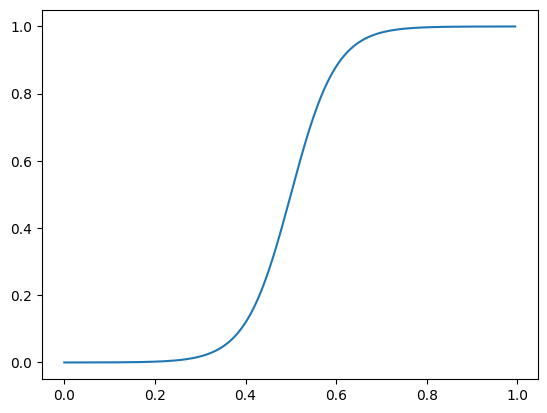

In [70]:
x = np.arange(0.,1.,0.005)
y = list(map(lambda x: sigmoid(x),x))
plt.plot(x,y)

<p>We assign a value to each HPO term in the following way:</p>
<p>value = #HPOterm * sigmoid(p(HPOterm))</p>
<p>Where #HPOterm is the numebr of times it appears in their group and p() the frequency of the term in their group</p>

In [71]:
for i in HPONeuro.keys():
    HPONeuro[i] = HPONeuro[i] * sigmoid(HPONeuro[i]/totalNum[i])

for i in HPOImmuno.keys():
    HPOImmuno[i] = HPOImmuno[i] * sigmoid(HPOImmuno[i]/totalNum[i])

for i in HPOCardio.keys():
    HPOCardio[i] = HPOCardio[i] * sigmoid(HPOCardio[i]/totalNum[i])

for i in HPOResp.keys():
    HPOResp[i] = HPOResp[i] * sigmoid(HPOResp[i]/totalNum[i])

In [72]:
bestNeuro = sorted(HPONeuro, key=HPONeuro.get, reverse=True)
bestImmuno = sorted(HPOImmuno, key=HPOImmuno.get, reverse=True)
bestCardio = sorted(HPOCardio, key=HPOCardio.get, reverse=True)
bestResp = sorted(HPOResp, key=HPOResp.get, reverse=True)

<h3>Our comparison set of HPO will be selected by the first N HPO ordered by the value stated above</h3>

In [73]:
N = 100
t1 = bestNeuro[0:N]
t2 = bestImmuno[0:N]
t3 = bestCardio[0:N]
t4 = bestResp[0:N]

In [74]:
t1[0:10]

['HP:0001417',
 'HP:0001419',
 'HP:0034434',
 'HP:0001423',
 'HP:0000718',
 'HP:0001344',
 'HP:0000750',
 'HP:0002463',
 'HP:0002167',
 'HP:0001257']

In [75]:
print(len(set.intersection(set(t1),set(t2))))
print(len(set.intersection(set(t1),set(t3))))
print(len(set.intersection(set(t1),set(t4))))
print(len(set.intersection(set(t2),set(t3))))
print(len(set.intersection(set(t2),set(t4))))
print(len(set.intersection(set(t3),set(t4))))

0
0
0
0
0
1


<h3>Tests</h3>

In [76]:
tN = random.sample(flatten(list(dNeuro.values())), 40)

In [77]:
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])

9.320887483799792
9.103580434071882


<p>We select 40 random HPO terms from the Neuro group and compare it to the most significant HPO from groups Neuro and Immuno</p>

In [78]:
N = 100
rNeuro = []
rImmuno = []
for j in range(N):
    tN = random.sample(flatten(list(dNeuro.values())), 40)

    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
    rNeuro.append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t2]) + '?metric=ancestor_information_content')
    rImmuno.append(response.json()['average_score'])

<h3>Results</h3>

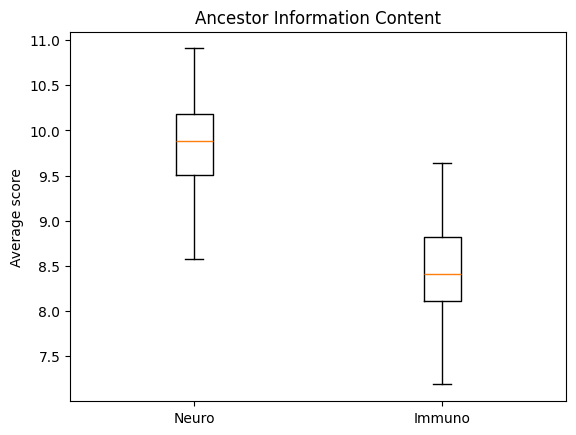

In [79]:
boxplot_data = [
    rNeuro,
    rImmuno
]
labels = ['Neuro', 'Immuno']

fig, ax = plt.subplots()
plt.title('Ancestor Information Content')
ax.set_ylabel('Average score')

bplot = ax.boxplot(boxplot_data,
                   tick_labels=labels)

plt.show()

In [80]:
j = 0
for i in range(len(rNeuro)):
    if rNeuro[i] > rImmuno[i]:
        j +=1
print(f'Accuracy: {j}%')

Accuracy: 99%


In [81]:
N = 100
rNeuro = []
rCardio = []
for j in range(N):
    tN = random.sample(flatten(list(dNeuro.values())), 40)

    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
    rNeuro.append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t3]) + '?metric=ancestor_information_content')
    rCardio.append(response.json()['average_score'])

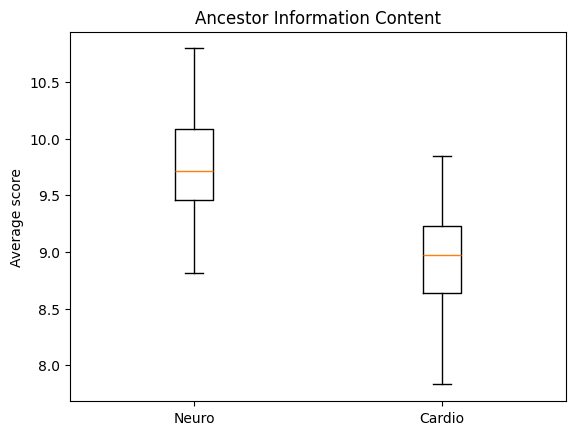

In [82]:
boxplot_data = [
    rNeuro,
    rCardio
]
labels = ['Neuro', 'Cardio']

fig, ax = plt.subplots()
plt.title('Ancestor Information Content')
ax.set_ylabel('Average score')

bplot = ax.boxplot(boxplot_data,
                   tick_labels=labels)

plt.show()

In [83]:
j = 0
for i in range(len(rNeuro)):
    if rNeuro[i] > rCardio[i]:
        j +=1
print(f'Accuracy: {j}%')

Accuracy: 93%


<h3>We define setA as 40 random HPO from one of the four disease groups and compare it to the four most significant HPO sets</h3>

In [85]:
N = 100
matrix = [[],[],[],[]]
mType = []
types = [dNeuro,dImmuno,dCardio,dResp]
random.seed(12)
for j in range(N):
    i = random.choice([0,1,2,3])
    mType.append(i)
    tN = random.sample(flatten(list(types[i].values())), 40)

    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
    matrix[0].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t2]) + '?metric=ancestor_information_content')
    matrix[1].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t3]) + '?metric=ancestor_information_content')
    matrix[2].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t4]) + '?metric=ancestor_information_content')
    matrix[3].append(response.json()['average_score'])
        

<p>Results</p>

In [86]:
j = 0
for i in range(len(matrix[0])):
    l = [matrix[0][i],matrix[1][i],matrix[2][i],matrix[3][i]]
    m = max(range(len(l)), key=l.__getitem__)
    if m == mType[i]:
        j += 1

print(f'Accuracy: {j/N*100}%')

Accuracy: 77.0%


<p>Target set N=20 Most Significant Sets N = 100</p>

In [87]:
N = 100
matrix = [[],[],[],[]]
mType = []
types = [dNeuro,dImmuno,dCardio,dResp]
random.seed(12)
for j in range(N):
    i = random.choice([0,1,2,3])
    mType.append(i)
    tN = random.sample(flatten(list(types[i].values())), 20)

    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
    matrix[0].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t2]) + '?metric=ancestor_information_content')
    matrix[1].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t3]) + '?metric=ancestor_information_content')
    matrix[2].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t4]) + '?metric=ancestor_information_content')
    matrix[3].append(response.json()['average_score'])

In [88]:
j = 0
for i in range(len(matrix[0])):
    l = [matrix[0][i],matrix[1][i],matrix[2][i],matrix[3][i]]
    m = max(range(len(l)), key=l.__getitem__)
    if m == mType[i]:
        j += 1

print(f'Accuracy: {j/N*100}%')

Accuracy: 67.0%


In [89]:
N = 500
t1 = bestNeuro[0:N]
t2 = bestImmuno[0:N]
t3 = bestCardio[0:N]
t4 = bestResp[0:N]

<p>Target set N=40 Most Significant Sets N = 500</p>

In [ ]:
N = 100
matrix = [[],[],[],[]]
mType = []
types = [dNeuro,dImmuno,dCardio,dResp]
random.seed(12)
for j in range(N):
    i = random.choice([0,1,2,3])
    mType.append(i)
    tN = random.sample(flatten(list(types[i].values())), 40)

    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
    matrix[0].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t2]) + '?metric=ancestor_information_content')
    matrix[1].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t3]) + '?metric=ancestor_information_content')
    matrix[2].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t4]) + '?metric=ancestor_information_content')
    matrix[3].append(response.json()['average_score'])

In [ ]:
j = 0
for i in range(len(matrix[0])):
    l = [matrix[0][i],matrix[1][i],matrix[2][i],matrix[3][i]]
    m = max(range(len(l)), key=l.__getitem__)
    if m == mType[i]:
        j += 1

print(f'Accuracy: {j/N*100}%')

<p>Target set N=20 Most Significant Sets N = 500</p>

In [ ]:
N = 100
matrix = [[],[],[],[]]
mType = []
types = [dNeuro,dImmuno,dCardio,dResp]
random.seed(12)
for j in range(N):
    i = random.choice([0,1,2,3])
    mType.append(i)
    tN = random.sample(flatten(list(types[i].values())), 20)

    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t1]) + '?metric=ancestor_information_content')
    matrix[0].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t2]) + '?metric=ancestor_information_content')
    matrix[1].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t3]) + '?metric=ancestor_information_content')
    matrix[2].append(response.json()['average_score'])
    response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([tN, t4]) + '?metric=ancestor_information_content')
    matrix[3].append(response.json()['average_score'])

In [ ]:
j = 0
for i in range(len(matrix[0])):
    l = [matrix[0][i],matrix[1][i],matrix[2][i],matrix[3][i]]
    m = max(range(len(l)), key=l.__getitem__)
    if m == mType[i]:
        j += 1

print(f'Accuracy: {j/N*100}%')

<p>Most Significant Test AIC scores for N=100 and N=300</p>

In [ ]:
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t1, t2]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t1, t3]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t1, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t2, t3]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t2, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t3, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])

In [ ]:
N = 300
t1 = bestNeuro[0:N]
t2 = bestImmuno[0:N]
t3 = bestCardio[0:N]
t4 = bestResp[0:N]

In [ ]:
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t1, t2]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t1, t3]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t1, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t2, t3]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t2, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])
response = requests.get('https://monarchinitiative.org/v3/api/semsim/compare/'+ prepareRequest([t3, t4]) + '?metric=ancestor_information_content')
print(response.json()['average_score'])